# COMP3134 BI & CRM Project – Group 6 Notebook

Source files:
- sales_6.csv
- customers_6.csv
- products_6.csv

In [1]:
import sys
import os
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 6)

print("Python:", sys.version)
print("Pandas:", pd.__version__)
print("NumPy:", np.__version__)

Python: 3.12.3 | packaged by conda-forge | (main, Apr 15 2024, 18:20:11) [MSC v.1938 64 bit (AMD64)]
Pandas: 2.3.3
NumPy: 1.26.4


In [2]:
# File Paths
DATA_DIR = Path('./data')
OUTPUT_DIR = Path('./output')
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
IMAGE_OUTPUT_DIR = OUTPUT_DIR / 'image'
IMAGE_OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
CSV_DIR = OUTPUT_DIR / 'csv'
CSV_DIR.mkdir(parents=True, exist_ok=True)

sales_file = DATA_DIR / 'sales_6.csv'
customers_file = DATA_DIR / 'customers_6.csv'
products_file = DATA_DIR / 'products_6.csv'

## Data Process

### Data Preview

In [3]:
# Load raw data
sales_raw = pd.read_csv(sales_file)
customers = pd.read_csv(customers_file)
products = pd.read_csv(products_file)

# Quick preview
display(sales_raw.head())
display(customers.head())
display(products.head())

,Invoice no,Customer id,Product id list,Invoice date,Shopping mall
0,INV00001,C00712,P00442,25/12/2025,MK
1,INV00002,C00168,"P00270,P00442",16/05/2024,CYB
2,INV00003,C00904,"P00530,P00355,P00522,P00224",01/07/2024,ST
3,INV00004,C01112,P00157,31/03/2025,TKO
4,INV00005,C00361,"P00160,P00020,P00116,P00165",09/08/2024,ST


,Customer id,Gender,Age,Payment method
0,C00001,M,19,Credit Card
1,C00002,M,47,Cash
2,C00003,M,51,Cash
3,C00004,M,31,Cash
4,C00005,M,27,Cash


,Product id,Category,Price
0,P00001,Groceries,232.56
1,P00002,Electronics,5462.98
2,P00003,Groceries,166.36
3,P00004,Electronics,1561.48
4,P00005,Books,279.14


### Data Information Checking

In [4]:
sales_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4348 entries, 0 to 4347
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Invoice no       4348 non-null   object
 1   Customer id      4348 non-null   object
 2   Product id list  4348 non-null   object
 3   Invoice date     4348 non-null   object
 4   Shopping mall    4348 non-null   object
dtypes: object(5)
memory usage: 170.0+ KB


In [5]:
customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1178 entries, 0 to 1177
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Customer id     1178 non-null   object
 1   Gender          1178 non-null   object
 2   Age             1178 non-null   int64 
 3   Payment method  1178 non-null   object
dtypes: int64(1), object(3)
memory usage: 36.9+ KB


In [6]:
products.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 535 entries, 0 to 534
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Product id  535 non-null    object 
 1   Category    535 non-null    object 
 2   Price       535 non-null    float64
dtypes: float64(1), object(2)
memory usage: 12.7+ KB


### Data Value Checking

In [7]:
# Basic data quality checks and type handling
print("Missing values (sales):")
print(sales_raw.isna().sum())
print("Missing values (customers):")
print(customers.isna().sum())
print("Missing values (products):")
print(products.isna().sum())

Missing values (sales):
Invoice no         0
Customer id        0
Product id list    0
Invoice date       0
Shopping mall      0
dtype: int64
Missing values (customers):
Customer id       0
Gender            0
Age               0
Payment method    0
dtype: int64
Missing values (products):
Product id    0
Category      0
Price         0
dtype: int64


### Data Id Format Validation

In [8]:
# Format validation
invoice_format_ok = sales_raw['Invoice no'].str.match(r'^INV\d{5}$').all()
customer_format_ok = customers['Customer id'].str.match(r'^C\d{5}$').all()
product_format_ok = products['Product id'].str.match(r'^P\d{5}$').all()
print('Invoice format valid:', invoice_format_ok)
print('Customer format valid:', customer_format_ok)
print('Product format valid:', product_format_ok)

Invoice format valid: True
Customer format valid: True
Product format valid: True


### Date Parsing

In [9]:
# Date parsing
sales_raw['Invoice date'] = pd.to_datetime(sales_raw['Invoice date'], format='%d/%m/%Y', errors='coerce')

In [10]:

print('Earliest date:', sales_raw['Invoice date'].min(), '\nLatest date:', sales_raw['Invoice date'].max())

Earliest date: 2024-01-01 00:00:00 
Latest date: 2025-12-31 00:00:00


### Data Unique Value

In [11]:
# Unique values overview
print('Shopping Mall:\n', sales_raw['Shopping mall'].unique())
print('Gender:\n', customers['Gender'].unique())
print('Payment Method:\n', customers['Payment method'].unique())

Shopping Mall:
 ['MK' 'CYB' 'ST' 'TKO']
Gender:
 ['M' 'F']
Payment Method:
 ['Credit Card' 'Cash' 'Mobile Payment']


### Product List Split

In [12]:
# Split multi-product column (trim whitespace to keep IDs clean)
sales_raw['Product id list'] = sales_raw['Product id list'].str.split(',').apply(
    lambda lst: [pid.strip() for pid in lst] if isinstance(lst, list) else lst
)
exploded_sales = sales_raw.explode('Product id list')
# Rename 'Product id list' to 'Product id'
exploded_sales = exploded_sales.rename(columns={'Product id list': 'Product id'})
exploded_sales.head()

,Invoice no,Customer id,Product id,Invoice date,Shopping mall
0,INV00001,C00712,P00442,2025-12-25,MK
1,INV00002,C00168,P00270,2024-05-16,CYB
1,INV00002,C00168,P00442,2024-05-16,CYB
2,INV00003,C00904,P00530,2024-07-01,ST
2,INV00003,C00904,P00355,2024-07-01,ST


### Merged Data

In [13]:
# Merged Data
merged_products = pd.merge(exploded_sales, products, on='Product id', how='left')
merged_data = pd.merge(merged_products, customers, on='Customer id', how='left')
# Save and view
merged_data.to_csv(CSV_DIR / 'merged_data.csv', index=False, encoding='utf-8')
merged_data.head()

,Invoice no,Customer id,Product id,Invoice date,Shopping mall,Category,Price,Gender,Age,Payment method
0,INV00001,C00712,P00442,2025-12-25,MK,Toys,129.62,F,39,Cash
1,INV00002,C00168,P00270,2024-05-16,CYB,Electronics,1546.75,M,22,Credit Card
2,INV00002,C00168,P00442,2024-05-16,CYB,Toys,129.62,M,22,Credit Card
3,INV00003,C00904,P00530,2024-07-01,ST,Clothing,975.60,M,25,Cash
4,INV00003,C00904,P00355,2024-07-01,ST,Books,236.37,M,25,Cash


## Exploratory Data Analysis (EDA)

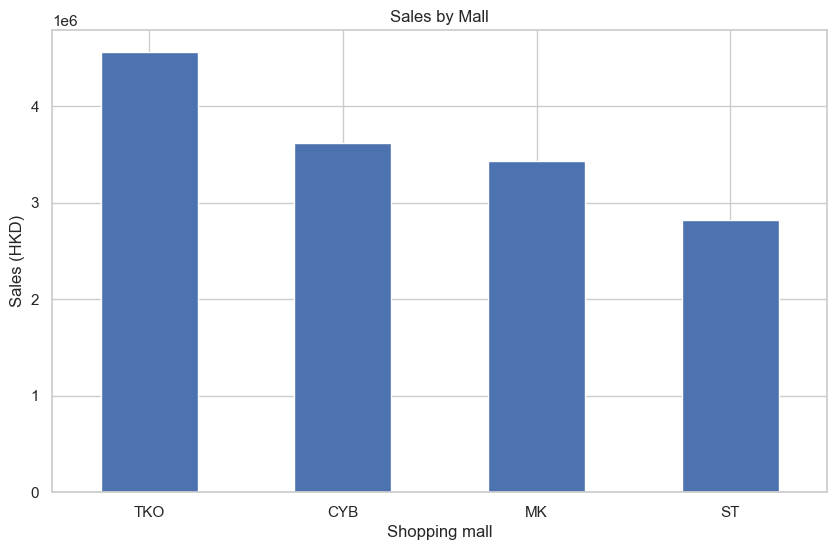

In [14]:
# Total sales / Sales by mall
mall_sales = merged_data.groupby('Shopping mall')['Price'].sum().sort_values(ascending=False)
mall_sales.plot(kind='bar', title='Sales by Mall')
plt.ylabel('Sales (HKD)')
plt.xticks(rotation=0)
plt.savefig(IMAGE_OUTPUT_DIR / 'sales_by_mall.png')
plt.show()

The sales performance of the shopping malls showed significant differences. **TKO Mall ranked first with sales of HKD 4.8 million**, contributing nearly one-third of the total revenue. **ST Mall only achieved HKD 2.8 million**, lagging behind by nearly 40%, which may be due to insufficient customer traffic, product variety, or promotional efforts.

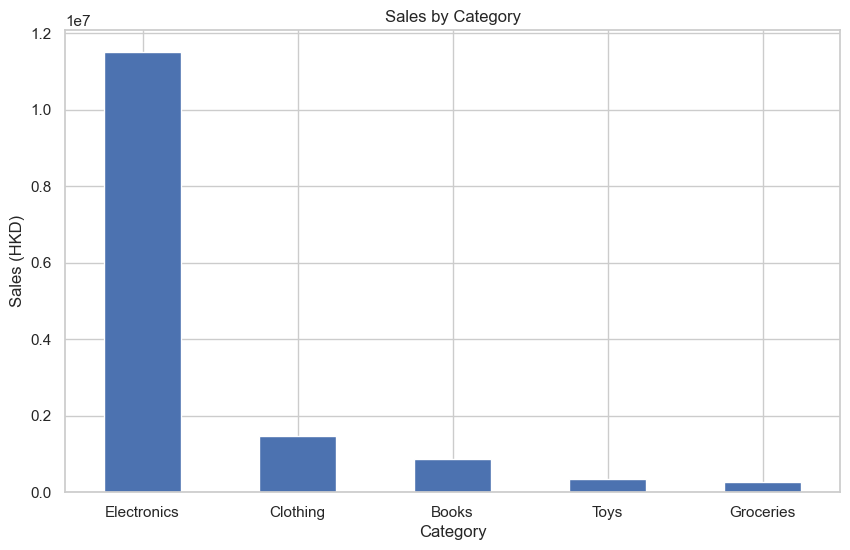

In [15]:
# Category revenue ranking
category_sales = merged_data.groupby('Category')['Price'].sum().sort_values(ascending=False)
category_sales.plot(kind='bar', title='Sales by Category')
plt.ylabel('Sales (HKD)')
plt.xticks(rotation=0)
plt.savefig(IMAGE_OUTPUT_DIR / 'sales_by_category.png')
plt.show()

As can be seen from the product category sales, **electronic products contributed 12 million in sales, accounting for nearly 70%**, indicating that customer consumption is highly concentrated on high-tech products.

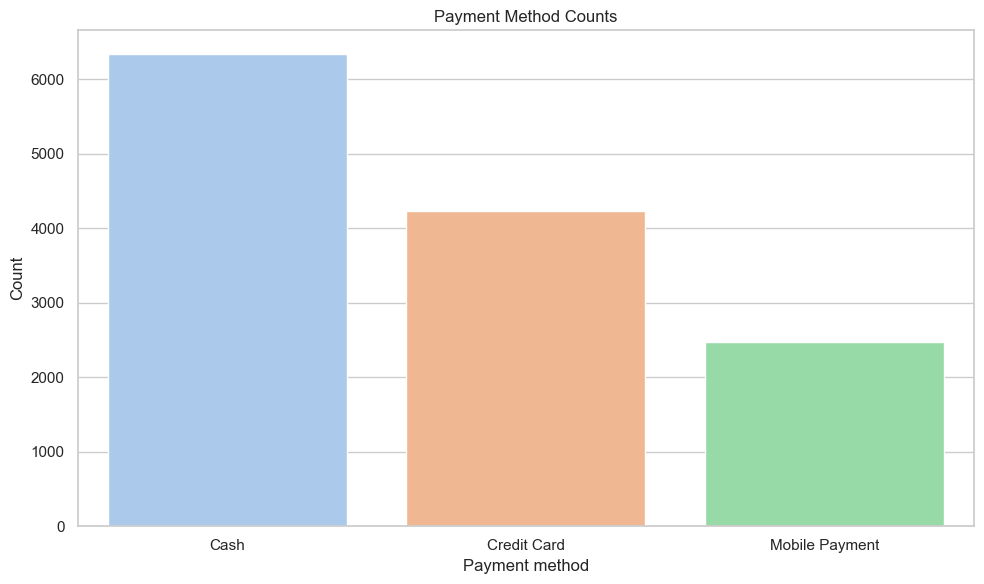

In [16]:
pay_counts = merged_data['Payment method'].value_counts(dropna=False).rename_axis('Payment method').reset_index(name='count')
pay_counts['pct'] = pay_counts['count'] / pay_counts['count'].sum()
sns.barplot(data=pay_counts, x='Payment method', y='count', palette='pastel', hue='Payment method', legend=False)
plt.title('Payment Method Counts')
plt.ylabel('Count')
plt.xticks(rotation=0, ha='center')
plt.tight_layout()
plt.savefig(IMAGE_OUTPUT_DIR / 'payment_method_counts.png')
plt.show()

Cash was the most (approximately 6.5k), followed by Credit Card (approximately 4.2k), and Mobile Payment was the least (approximately 2.4k).

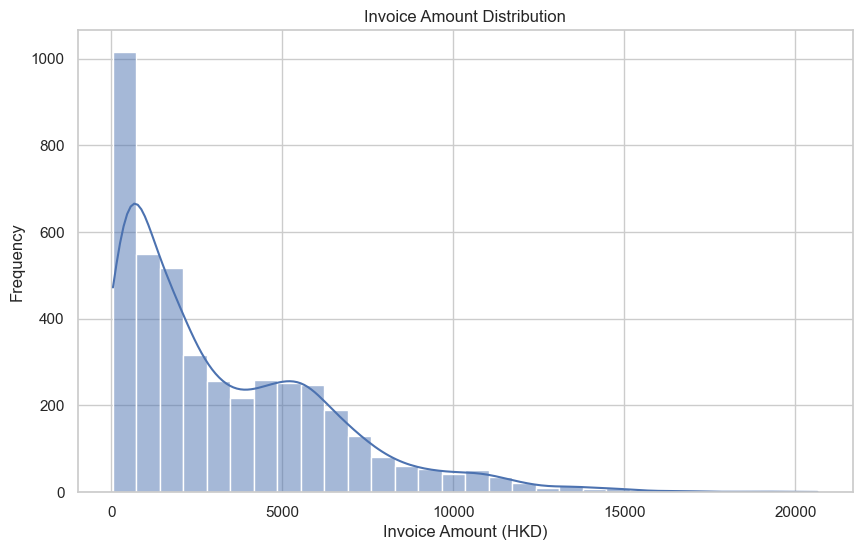

In [17]:
invoice_amounts = merged_data.groupby('Invoice no')['Price'].sum().reset_index(name='Invoice Amount')
sns.histplot(invoice_amounts['Invoice Amount'], bins=30, kde=True)
plt.title('Invoice Amount Distribution')
plt.xlabel('Invoice Amount (HKD)')
plt.ylabel('Frequency')
plt.savefig(IMAGE_OUTPUT_DIR / 'invoice_amount_distribution.png')
plt.show()

The invoice amount distribution shows a clear right skew, with a peak in the **500–1000 HKD** range, indicating that most customers primarily engage in small-amount purchases. Approximately **80% of invoices are below 5000 HKD**, suggesting that daily consumption is concentrated on low- to mid-priced goods.

However, a small number of long-tail invoices **above 10,000 HKD** exist, representing a potentially high-value customer group.

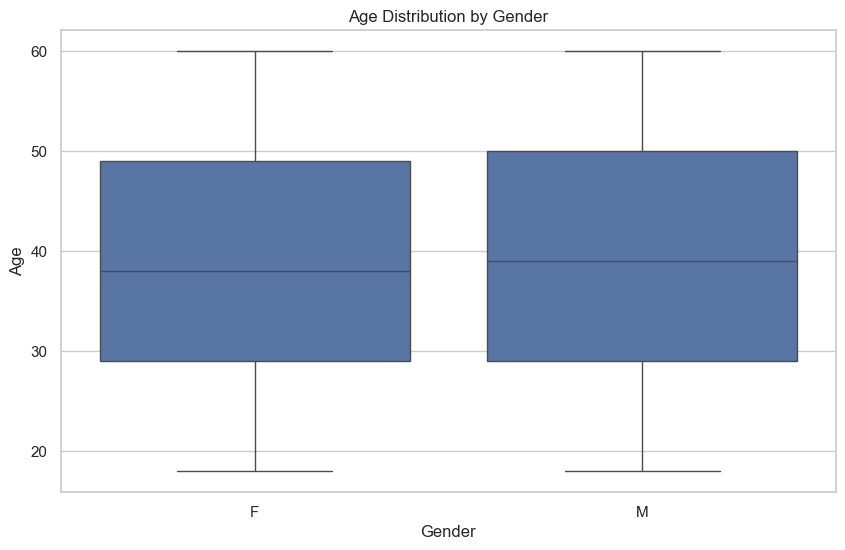

In [18]:
# Gender / Age distribution
sns.boxplot(data=merged_data.dropna(subset=['Age','Gender']), x='Gender', y='Age')
plt.title('Age Distribution by Gender')
plt.savefig(IMAGE_OUTPUT_DIR / 'age_distribution_by_gender.png')
plt.show()

The age distribution of male and female customers highly overlaps, with a median age of 40 for both, and the majority are concentrated in the 30-50 age group.

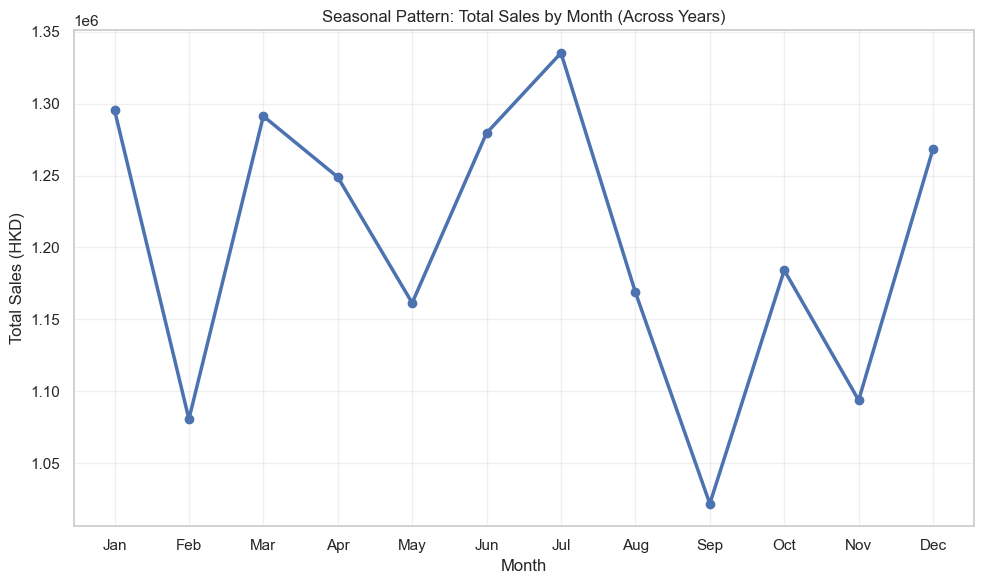

In [19]:
# Monthly trend & seasonality
merged_month = merged_data.copy()
merged_month['Year'] = merged_month['Invoice date'].dt.year
merged_month['Month'] = merged_month['Invoice date'].dt.month

seasonal_sales = merged_month.groupby('Month')['Price'].sum().reset_index()

plt.figure(figsize=(10, 6))
plt.plot(seasonal_sales['Month'], seasonal_sales['Price'], marker='o', linewidth=2.5)
plt.title('Seasonal Pattern: Total Sales by Month (Across Years)')
plt.xlabel('Month')
plt.ylabel('Total Sales (HKD)')
plt.xticks(range(1, 13),
           ['Jan','Feb','Mar','Apr','May','Jun',
            'Jul','Aug','Sep','Oct','Nov','Dec'])
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(IMAGE_OUTPUT_DIR / 'seasonal_sales_pattern.png')
plt.show()

Monthly sales trends fluctuate significantly, with **July reaching the highest of the year at 1.35 million and September the lowest at only 1 million**, showing no fixed seasonality.

## RFM Calculation

- R = Recency: Number of days since the last purchase (lower is better).
- F = Frequency: Number of transactions or invoices during the observation period (higher is better).
- M = Monetary: Total spending amount during the observation period (higher is better).

In [20]:
df = merged_data.copy()

In [21]:
# Find the last date in the dataset and plus one day to set as snapshot date
snapshot_date = df['Invoice date'].max() + pd.Timedelta(days=1)

In [22]:
# RFM Calculation
rfm = df.groupby('Customer id').agg(
    Monetary=('Price', 'sum'),
    Frequency=('Invoice no', 'nunique'),
    LastPurchase=('Invoice date', 'max')
).reset_index()

rfm['Recency'] = (snapshot_date - rfm['LastPurchase']).dt.days
rfm = rfm.drop(columns=['LastPurchase'])
rfm.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1149 entries, 0 to 1148
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Customer id  1149 non-null   object 
 1   Monetary     1149 non-null   float64
 2   Frequency    1149 non-null   int64  
 3   Recency      1149 non-null   int64  
dtypes: float64(1), int64(2), object(1)
memory usage: 36.0+ KB


## Customer Segmentation (KMeans)

In [23]:
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

In [24]:
# Feature selection for clustering
feat_cols = ['Recency','Frequency','Monetary']

X = rfm[feat_cols].fillna(0).copy()
X.head()

,Recency,Frequency,Monetary
0,59,3,11663.89
1,10,4,9110.17
2,164,2,11245.63
3,165,6,16331.02
4,217,5,9873.15


In [25]:
# Choose scaling method
scaler = RobustScaler()
X_scaled = scaler.fit_transform(X)

In [26]:
# Determine optimal number of clusters using silhouette score
sil_scores = {}
for k in range(2, 9):
    km = KMeans(n_clusters=k, random_state=42, n_init=10).fit(X_scaled)
    sil = silhouette_score(X_scaled, km.labels_)
    sil_scores[k] = sil
best_k = max(sil_scores, key=sil_scores.get)
print('silhouette scores:', {k: round(v,3) for k,v in sil_scores.items()})
print('Select best_k =', best_k)

a:\CCW\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] 系統找不到指定的檔案。
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "a:\CCW\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "a:\CCW\anaconda3\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "a:\CCW\anaconda3\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "a:\CCW\anaconda3\Lib\subprocess.py", line 1538, in _execute_child
    hp, ht, pid, tid = _winapi.CreateProcess(executable, args,
                       ^^^^^^^^^^^^^^^^^^^^^^^^

silhouette scores: {2: 0.362, 3: 0.375, 4: 0.314, 5: 0.297, 6: 0.313, 7: 0.289, 8: 0.279}
Select best_k = 3


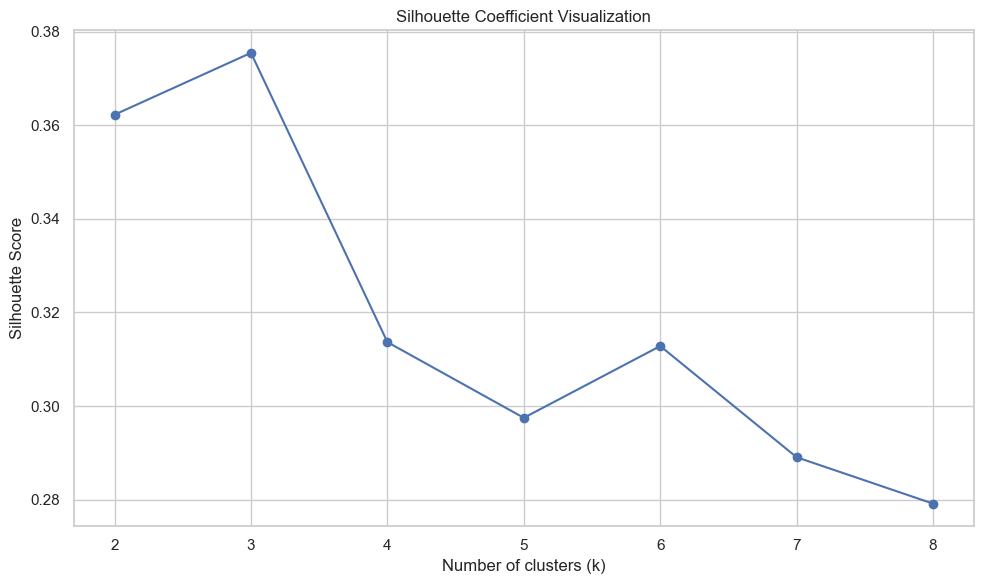

In [27]:
# Silhouette Cofficient Visualization
plt.plot(sil_scores.keys(), sil_scores.values(), marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Coefficient Visualization')
plt.tight_layout()
plt.savefig(IMAGE_OUTPUT_DIR / 'silhouette_coefficient.png')
plt.show()

In [28]:
# Final clustering with best_k
km = KMeans(n_clusters=best_k, random_state=42, n_init=20).fit(X_scaled)
rfm['cluster'] = km.labels_

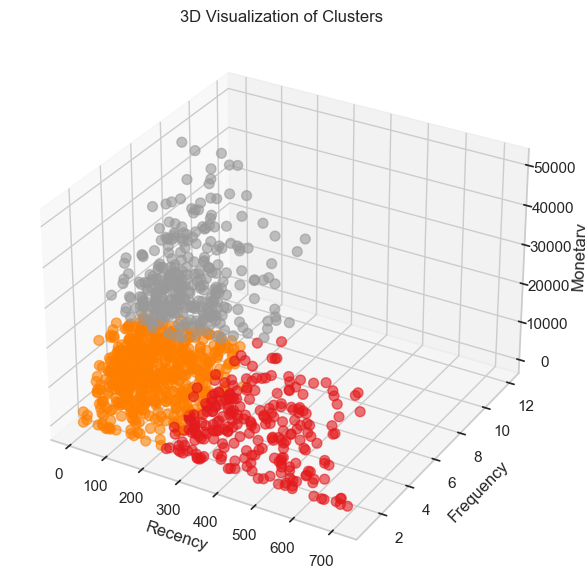

In [29]:
# Visualization of clusters in 3D
ax = plt.figure().add_subplot(111, projection='3d')

scatter = ax.scatter(
    rfm['Recency'], rfm['Frequency'], rfm['Monetary'],
    c=rfm['cluster'], cmap='Set1', s=50, alpha=0.6
)

plt.xlabel('Recency')
plt.ylabel('Frequency')
ax.set_zlabel('Monetary')
plt.title('3D Visualization of Clusters')
plt.tight_layout()
plt.savefig(IMAGE_OUTPUT_DIR / 'customer_clusters_3d.png')
plt.show()

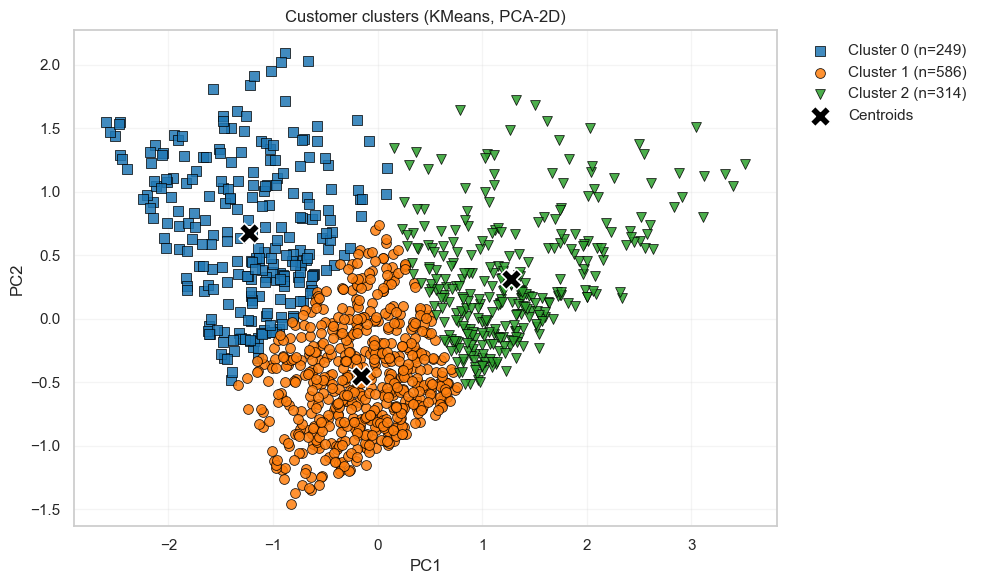

In [30]:
# Visualize clusters using PCA
pca = PCA(n_components=2)
proj = pca.fit_transform(X_scaled)

centroids_pca = pca.transform(km.cluster_centers_)

clusters = sorted(rfm['cluster'].unique())
markers = ['s','o','v','^','P','X','D','*','<','>']
palette = sns.color_palette('tab10', n_colors=max(10, len(clusters)))

for i, cl in enumerate(clusters):
    mask = (rfm['cluster'] == cl).values
    col = palette[i % len(palette)]
    m = markers[i % len(markers)]
    plt.scatter(proj[mask, 0], proj[mask, 1],
                s=50, c=[col], marker=m, edgecolors='black', linewidths=0.6,
                alpha=0.85, label=f'Cluster {cl} (n={mask.sum()})')

plt.scatter(centroids_pca[:,0], centroids_pca[:,1],
            marker='X', s=220, c='black', edgecolors='white', linewidths=1.2, zorder=6, label='Centroids')

plt.title('Customer clusters (KMeans, PCA-2D)')
plt.xlabel('PC1'); plt.ylabel('PC2')
plt.grid(alpha=0.2)
plt.legend(bbox_to_anchor=(1.02,1), loc='upper left', frameon=False)
plt.tight_layout()
plt.savefig(IMAGE_OUTPUT_DIR / 'customer_clusters_pca.png')
plt.show()

- Moving right or up: This indicates a better overall performance in R, F, and M (more frequent visits, higher spending), representing a **"high-value"** area.
- Moving left or down: This indicates fewer visits and lower spending, representing a **low-value/low-participation** area.

In [31]:
# Cluster summary
cluster_summary = rfm.groupby('cluster').agg(
    customers=('Customer id','count'),
    mean_recency=('Recency','mean'),
    mean_frequency=('Frequency','mean'),
    mean_monetary=('Monetary','mean'),
    median_monetary=('Monetary','median')
).reset_index().sort_values('customers', ascending=False)
cluster_summary

,cluster,customers,mean_recency,mean_frequency,mean_monetary,median_monetary
1,1,586,116.904437,3.250853,8981.111945,8813.985
2,2,314,101.984076,5.984076,23749.517930,22118.465
0,0,249,419.172691,2.265060,6866.788273,6250.130


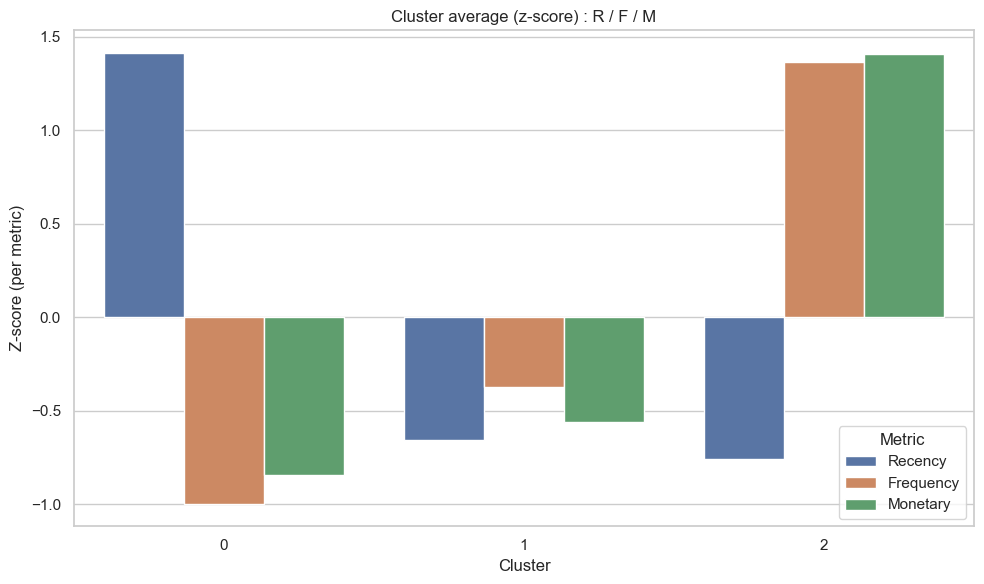

In [32]:
# Cluster RFM means (z-score)
cluster_means = rfm.groupby('cluster')[['Recency','Frequency','Monetary']].mean().reset_index()

# Normalize to z-score per metric
cluster_means_norm = cluster_means.copy()
cluster_means_norm[['Recency','Frequency','Monetary']] = cluster_means_norm[['Recency','Frequency','Monetary']].apply(
    lambda x: (x - x.mean()) / (x.std(ddof=0) + 1e-9)
)
cluster_means_melt = cluster_means_norm.melt(id_vars='cluster', var_name='metric', value_name='z_value')

# Plot cluster means (z-score)
sns.barplot(data=cluster_means_melt, x='cluster', y='z_value', hue='metric')
plt.title('Cluster average (z-score) : R / F / M')
plt.xlabel('Cluster'); plt.ylabel('Z-score (per metric)')
plt.legend(title='Metric'); plt.tight_layout()
plt.savefig(IMAGE_OUTPUT_DIR / 'cluster_rfm_means_zscore.png')
plt.show()
plt.close()

This reveals the differences between the three customer segments:
- Cluster 0: Occasional purchases with low spending
- Cluster 1: Regular purchases with moderate spending
- Cluster 2: Higher spending and frequent customers

## Purchasing Habits of 3 Clusters

In [33]:
merged_with_cluster = merged_data.merge(
    rfm[['Customer id', 'cluster']],
    on='Customer id',
    how='left'
)
merged_with_cluster.head()

,Invoice no,Customer id,Product id,Invoice date,Shopping mall,Category,Price,Gender,Age,Payment method,cluster
0,INV00001,C00712,P00442,2025-12-25,MK,Toys,129.62,F,39,Cash,1
1,INV00002,C00168,P00270,2024-05-16,CYB,Electronics,1546.75,M,22,Credit Card,1
2,INV00002,C00168,P00442,2024-05-16,CYB,Toys,129.62,M,22,Credit Card,1
3,INV00003,C00904,P00530,2024-07-01,ST,Clothing,975.60,M,25,Cash,2
4,INV00003,C00904,P00355,2024-07-01,ST,Books,236.37,M,25,Cash,2


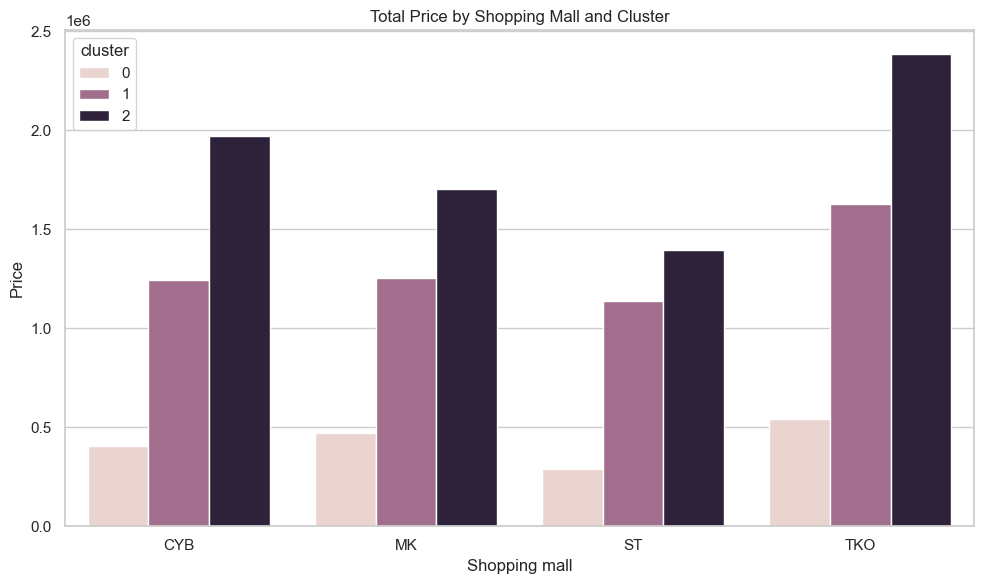

In [34]:
mall_by_cluster = merged_with_cluster.groupby(['cluster','Shopping mall'])['Price'].sum().reset_index()
sns.barplot(data=mall_by_cluster, x='Shopping mall', y='Price', hue='cluster')
plt.xticks(rotation=0)
plt.title('Total Price by Shopping Mall and Cluster')
plt.tight_layout()
plt.savefig(IMAGE_OUTPUT_DIR / 'total_price_by_shopping_mall_and_cluster.png')
plt.show()

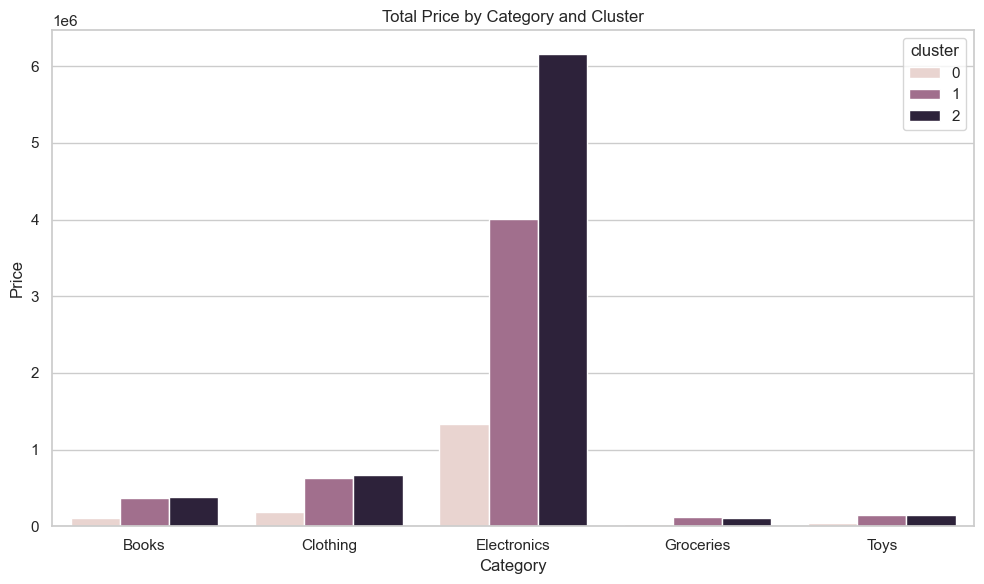

In [35]:
category_by_cluster = merged_with_cluster.groupby(['cluster','Category'])['Price'].sum().reset_index()
sns.barplot(data=category_by_cluster, x='Category', y='Price', hue='cluster')
plt.xticks(rotation=0)
plt.title('Total Price by Category and Cluster')
plt.tight_layout()
plt.savefig(IMAGE_OUTPUT_DIR / 'total_price_by_category_and_cluster.png')
plt.show()

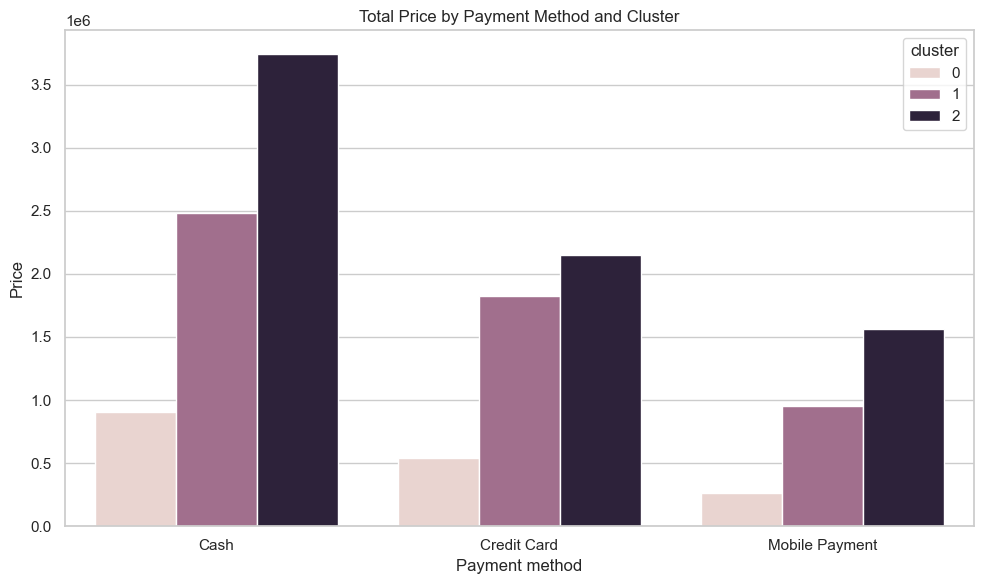

In [36]:
paymethod_by_cluster = merged_with_cluster.groupby(['cluster','Payment method'])['Price'].sum().reset_index()
sns.barplot(data=paymethod_by_cluster, x='Payment method', y='Price', hue='cluster')
plt.xticks(rotation=0)
plt.title('Total Price by Payment Method and Cluster')
plt.tight_layout()
plt.savefig(IMAGE_OUTPUT_DIR / 'total_price_by_payment_method_and_cluster.png')
plt.show()

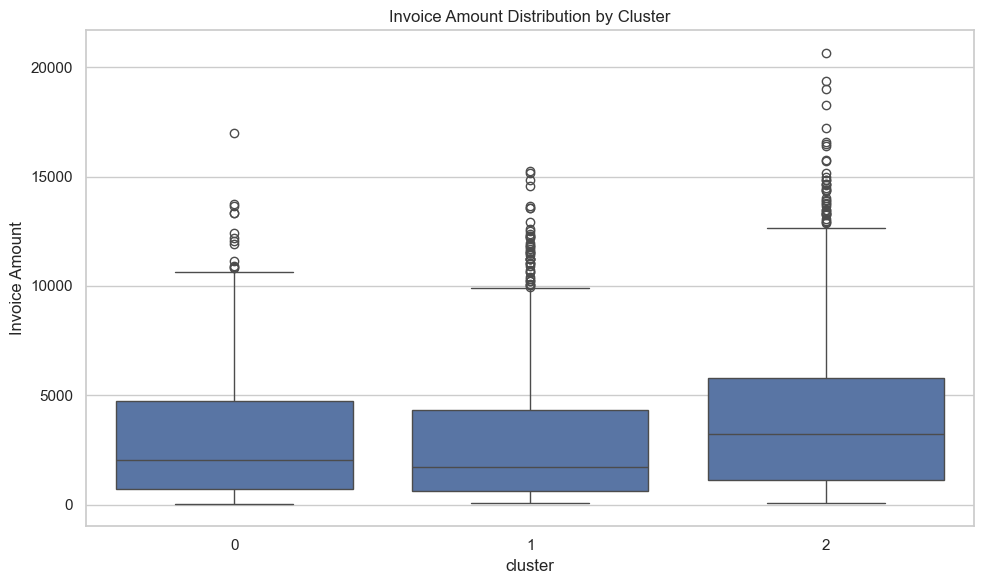

In [37]:
invoice_amounts = merged_with_cluster.groupby(['cluster','Invoice no'])['Price'].sum().reset_index(name='Invoice Amount')
sns.boxplot(data=invoice_amounts, x='cluster', y='Invoice Amount')
plt.title('Invoice Amount Distribution by Cluster')
plt.tight_layout()
plt.savefig(IMAGE_OUTPUT_DIR / 'invoice_amount_distribution_by_cluster.png')
plt.show()